In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

nbn = "03_" # Notebook Number; Prefix for artifacts path

In [27]:
datasets = ["DTD","EuroSAT","GTSRB","MNIST","SVHN","Caltech256"]
# datasets = ["DTD","EuroSAT","Caltech256"]
nrow, ncol=2, 3

In [28]:
def calc_tpr(targ, pred):
    tp = np.sum((targ == 1) & (pred == 1))
    fn = np.sum((targ == 1) & (pred == 0))
    return tp / (tp + fn)
def calc_fpr(targ, pred):
    fp = np.sum((targ == 0) & (pred == 1))
    tn = np.sum((targ == 0) & (pred == 0))
    return fp / (fp + tn)
def predict_correctness(ent_ls,threshold):
    return np.where(ent_ls>threshold,0,1)

In [29]:
def auroc(pred_vec, target_vec, unc_vec, label, ax):
    cor_pred = np.where(pred_vec == target_vec, 1, 0)
    max_unc = unc_vec.max()
    min_unc = unc_vec.min()
    tpr = np.array([]) 
    fpr = np.array([])
    step = (max_unc - min_unc) / 200
    print(f"{max_unc = }, {min_unc = }, {step = }")
    for ent_step in np.arange(min_unc, max_unc+step, step):
        temp = predict_correctness(unc_vec, ent_step)
        tpr = np.append(tpr, calc_tpr(cor_pred, temp))
        fpr = np.append(fpr, calc_fpr(cor_pred, temp))
    area = np.trapz(tpr, fpr)
    sns.lineplot(x=fpr, y=tpr, label=f"{label} (AUC: {area:.2f})", ax=ax)
    return area

/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


max_unc = 3.0485568336868796, min_unc = -18.159208400188714, step = 0.10603882616937797
max_unc = 2.8706943839517027, min_unc = -18.778603727511253, step = 0.10824649055731478
max_unc = 1.0524103009521215, min_unc = -36.30097853439988, step = 0.18676694417675999
max_unc = 1.0247267365767192, min_unc = -25.773246847542463, step = 0.13398986792059592
max_unc = 1.0720142709505842, min_unc = -21.553541232668817, step = 0.11312777751809701
max_unc = 3.05924499014354, min_unc = -17.57434331985722, step = 0.1031679415500038
max_unc = 2.875960237069509, min_unc = -16.17729102637454, step = 0.09526625631722024
max_unc = 3.0319281645847695, min_unc = -35.880080468343344, step = 0.19456004316464057
max_unc = 3.2712566034682604, min_unc = -52.419074135851545, step = 0.278451653696599
max_unc = 2.925346445256865, min_unc = -15.521937172616695, step = 0.09223641808936779
max_unc = 3.3059535342932587, min_unc = -35.87935403609622, step = 0.19592653785194739
max_unc = 2.405236159057866, min_unc = -27.

/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


max_unc = 2.5253029817454875, min_unc = -33.131940169043446, step = 0.17828621575394468
max_unc = 0.008999611780866982, min_unc = -25.555456950701643, step = 0.12782228281241254
max_unc = 0.2515948793318983, min_unc = -31.87063919961475, step = 0.16061117039473324
max_unc = 0.21259150599717191, min_unc = -40.83280918393283, step = 0.20522700344965003
max_unc = 2.4128448758120515, min_unc = -23.722998863342788, step = 0.1306792186957742
max_unc = 2.573672033178735, min_unc = -41.05689854164246, step = 0.218152852874106
max_unc = 2.0459928662062916, min_unc = -60.60066104673247, step = 0.3132332695646938
max_unc = 1.6558308376803184, min_unc = -49.07825408394071, step = 0.2536704246081052
max_unc = 2.619809065106001, min_unc = -40.245442766994316, step = 0.2143262591605016
max_unc = 2.0943619176395387, min_unc = -81.88970772557529, step = 0.4199203482160742


/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


max_unc = 3.0480991016443535, min_unc = -43.517348718536404, step = 0.23282723910090378
max_unc = 3.13432916312651, min_unc = -34.018605765335856, step = 0.18576467464231183
max_unc = 1.1281095799061076, min_unc = -47.5960878864666, step = 0.24362098733186355
max_unc = 0.8387558245894482, min_unc = -50.73892090935103, step = 0.2578883836697024
max_unc = 0.7238145512417087, min_unc = -33.84991394082642, step = 0.17286864246034064
max_unc = 3.0608556409729175, min_unc = -48.008765804464275, step = 0.255348107227186
max_unc = 3.1353290201237756, min_unc = -34.12142399345532, step = 0.1862837650678955
max_unc = 2.9584299458978967, min_unc = -62.6724808374975, step = 0.32815455391697695
max_unc = 3.5338058254002243, min_unc = -80.14754303718283, step = 0.41840674431291525
max_unc = 3.136327878405515, min_unc = -33.283335238319836, step = 0.18209831558362677
max_unc = 3.1324296099821636, min_unc = -67.97133793428173, step = 0.35551883772131954


/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


max_unc = 2.8228753118132, min_unc = -55.711997808697646, step = 0.2926743656025542
max_unc = 2.3723527498321566, min_unc = -53.345620909954675, step = 0.2785898682989342
max_unc = -0.055040242355747136, min_unc = -53.24552154717553, step = 0.2659524065240989
max_unc = 0.061635217166898695, min_unc = -62.837885227563355, step = 0.3144976022236513
max_unc = -0.23515772635009463, min_unc = -56.33996180374145, step = 0.2805240203869568
max_unc = 2.856363406401766, min_unc = -53.138476949556306, step = 0.2799742017797904
max_unc = 2.3830176715790046, min_unc = -56.48283580179471, step = 0.29432926736686854
max_unc = 0.8699134212003474, min_unc = -103.0950901483319, step = 0.5198250178476613
max_unc = 2.26597610893921, min_unc = -108.67155313288886, step = 0.5546876462091404
max_unc = 2.393570051959405, min_unc = -55.71570216710329, step = 0.29054636109531345
max_unc = 1.0563195714281781, min_unc = -112.82279760553615, step = 0.5693955858848216
max_unc = 3.37456403678513, min_unc = -54.0131

/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


max_unc = 3.209855617978607, min_unc = -52.165105262378425, step = 0.27687480440178514
max_unc = 0.6139268879162507, min_unc = -53.75482669186673, step = 0.2718437678989149
max_unc = 0.6014822635958381, min_unc = -57.00520874879722, step = 0.2880334550619653
max_unc = 0.4782734947172769, min_unc = -56.61321284649327, step = 0.28545743170605276
max_unc = 3.3754752160878034, min_unc = -54.3311030673956, step = 0.28853289141741706
max_unc = 3.2143701434086442, min_unc = -56.88054961651902, step = 0.30047459879963834
max_unc = 3.08798943794158, min_unc = -101.35600211555634, step = 0.5222199577674895
max_unc = 2.6692260585241576, min_unc = -103.38592503996992, step = 0.5302757554924704
max_unc = 3.2188643794614276, min_unc = -56.04482690948064, step = 0.29631845644471033
max_unc = 3.1495109347694976, min_unc = -113.49376246301229, step = 0.5832163669889089
max_unc = 2.3522818369705574, min_unc = -6.62071320035955, step = 0.04486497518665054
max_unc = 2.1629732506752437, min_unc = -7.164384

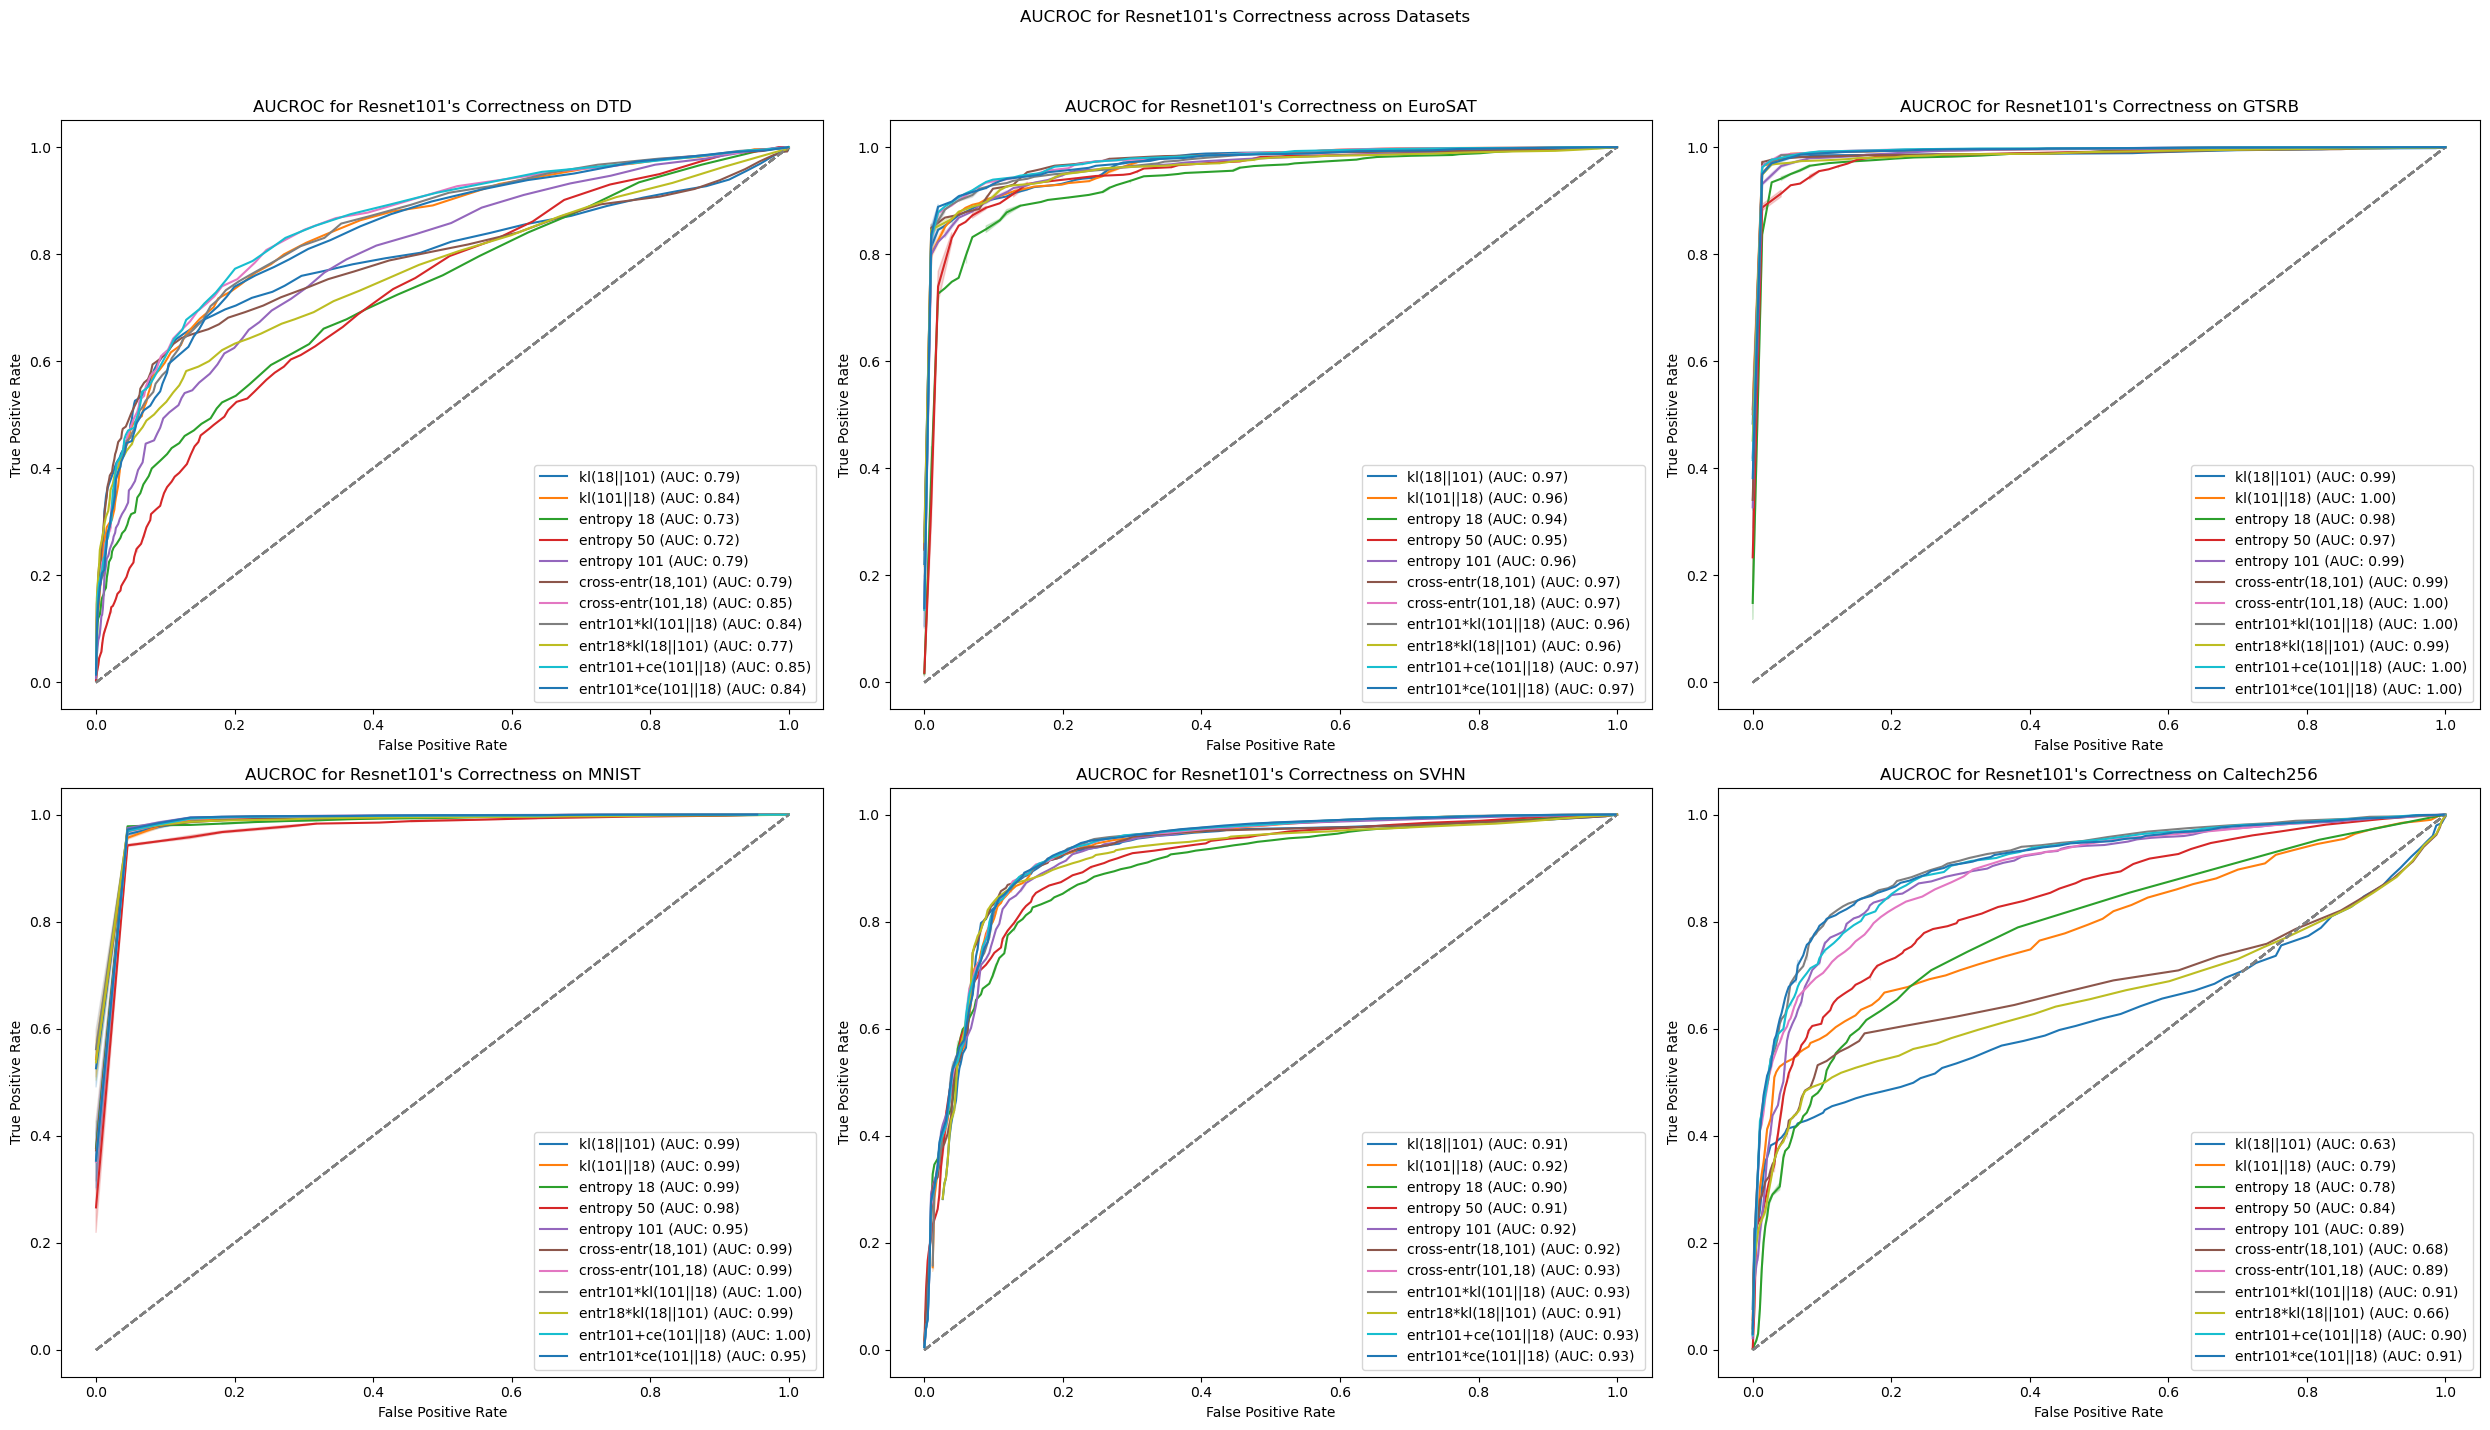

In [30]:
fig, axes = plt.subplots(nrow, ncol, figsize=(25, 15))

for i, ds in enumerate(datasets):
    pred = pd.read_csv(f"prediction_{ds}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"uncertainty_{ds}.csv", index_col="Unnamed: 0")
    
    metrics = [
        (np.log(unc_pred["kl_18_101"]), "kl(18||101)"),
        (np.log(unc_pred["kl_101_18"]), "kl(101||18)"),
        (np.log(unc_pred["ent_18"]), "entropy 18"),
        (np.log(unc_pred["ent_50"]), "entropy 50"),
        (np.log(unc_pred["ent_101"]), "entropy 101"),
        (np.log(unc_pred["ce_18_101"]), "cross-entr(18,101)"),
        (np.log(unc_pred["ce_101_18"]), "cross-entr(101,18)"),
        (np.log(unc_pred["ent_101"] * unc_pred["kl_101_18"]), "entr101*kl(101||18)"),
        (np.log(unc_pred["ent_18"] * unc_pred["kl_18_101"]), "entr18*kl(18||101)"),
        (np.log(unc_pred["ent_101"] + unc_pred["ce_101_18"]), "entr101+ce(101||18)"),
        (np.log(unc_pred["ent_101"] * unc_pred["ce_101_18"]), "entr101*ce(101||18)")
    ]
    
    ax = axes[i // ncol, i % ncol]
    for metric, label in metrics:
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
        auroc(pred["pred101"], pred["target"], metric, label, ax)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"AUCROC for Resnet101's Correctness on {ds}")
        ax.legend(loc="lower right")

plt.suptitle("AUCROC for Resnet101's Correctness across Datasets")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.savefig(f"artifacts/{nbn}aucroc.png")
plt.show()

/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


kl(18||50)
max_unc = 3.5807043185227196, min_unc = -21.78262769669479, step = 0.12681666007608755
kl(50||18)
max_unc = 3.123551517387888, min_unc = -21.47386735183, step = 0.12298709434608943
entropy 18
max_unc = 1.0524103009521215, min_unc = -36.30097853439988, step = 0.18676694417675999
entropy 50
max_unc = 1.0247267365767192, min_unc = -25.773246847542463, step = 0.13398986792059592
entropy 101
max_unc = 1.0720142709505842, min_unc = -21.553541232668817, step = 0.11312777751809701
cross-entr(18,50)
max_unc = 3.581939112381161, min_unc = -37.131406996444355, step = 0.2035667305441276
cross-entr(50,18)
max_unc = 3.1294526198608565, min_unc = -25.850542543083915, step = 0.14489997581472386
entr50*kl(50||18)
max_unc = 3.0131103339816603, min_unc = -41.41048137093193, step = 0.22211795852456795
entr18*kl(18||50)
max_unc = 3.355498478481737, min_unc = -42.05087205886791, step = 0.22703185268674822
entr50+ce(50||18)
max_unc = 3.135319103512767, min_unc = -25.118000872527958, step = 0.14126

/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


kl(18||50)
max_unc = 2.652466931420437, min_unc = -26.60968522259214, step = 0.1463107607700629
kl(50||18)
max_unc = 2.112093438017459, min_unc = -32.76911187552695, step = 0.17440602656772206
entropy 18
max_unc = 0.008999611780866982, min_unc = -25.555456950701643, step = 0.12782228281241254
entropy 50
max_unc = 0.2515948793318983, min_unc = -31.87063919961475, step = 0.16061117039473324
entropy 101
max_unc = 0.21259150599717191, min_unc = -40.83280918393283, step = 0.20522700344965003
cross-entr(18,50)
max_unc = 2.675426831634263, min_unc = -23.83166955548572, step = 0.1325354819355999
cross-entr(50,18)
max_unc = 2.114516733008778, min_unc = -31.92567001465297, step = 0.17020093373830875
entr50*kl(50||18)
max_unc = 1.5507801723684758, min_unc = -61.03086964837806, step = 0.31290824910373266
entr18*kl(18||50)
max_unc = 1.5559399944192256, min_unc = -49.56660597111716, step = 0.25561272982768196
entr50+ce(50||18)
max_unc = 2.1346091235181066, min_unc = -31.204628925505205, step = 0.166

/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


kl(50||18)
max_unc = 2.742350564867597, min_unc = -50.909380336571054, step = 0.2682586545071933
entropy 18
max_unc = 1.1281095799061076, min_unc = -47.5960878864666, step = 0.24362098733186355
entropy 50
max_unc = 0.8387558245894482, min_unc = -50.73892090935103, step = 0.2578883836697024
entropy 101
max_unc = 0.7238145512417087, min_unc = -33.84991394082642, step = 0.17286864246034064
cross-entr(18,50)
max_unc = 2.8990051735271485, min_unc = -47.87245245936786, step = 0.25385728816447506
cross-entr(50,18)
max_unc = 2.7474446796330194, min_unc = -51.13459688691913, step = 0.2694102078327607
entr50*kl(50||18)
max_unc = 2.6765775472541145, min_unc = -98.48786186409505, step = 0.5058221970567458
entr18*kl(18||50)
max_unc = 3.4477719218769174, min_unc = -81.9545951756662, step = 0.4270118354877156
entr50+ce(50||18)
max_unc = 2.7525129758602453, min_unc = -50.22416812665576, step = 0.26488340551258005
entr50*ce(50||18)
max_unc = 2.811156207087661, min_unc = -101.87351779627015, step = 0.52

/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


kl(18||50)
max_unc = 100.0, min_unc = -54.130376106715914, step = 0.7706518805335796
kl(50||18)
max_unc = 2.5525198917754857, min_unc = -52.89846884004856, step = 0.2772549436591202
entropy 18
max_unc = -0.055040242355747136, min_unc = -53.24552154717553, step = 0.2659524065240989
entropy 50
max_unc = 0.061635217166898695, min_unc = -62.837885227563355, step = 0.3144976022236513
entropy 101
max_unc = -0.23515772635009463, min_unc = -56.33996180374145, step = 0.2805240203869568
cross-entr(18,50)
max_unc = 100.0, min_unc = -53.25408990813226, step = 0.7662704495406613
cross-entr(50,18)
max_unc = 2.5718212802691727, min_unc = -63.237941487500485, step = 0.32904881383884826
entr50*kl(50||18)
max_unc = 1.695390425270595, min_unc = -101.72530557191804, step = 0.5171034799859432
entr18*kl(18||50)
max_unc = 100.0, min_unc = -100.0, step = 1.0
entr50+ce(50||18)
max_unc = 2.5907571686919555, min_unc = -62.32489255259018, step = 0.32457824860641066
entr50*ce(50||18)
max_unc = 1.7786249229768456, 

/Users/timothyzhou/anaconda3/envs/ml/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


kl(18||50)
max_unc = 3.199115104128654, min_unc = -54.76468832742236, step = 0.28981901715775504
kl(50||18)
max_unc = 3.3660656148581376, min_unc = -53.2866628839469, step = 0.2832636424940252
entropy 18
max_unc = 0.6139268879162507, min_unc = -53.75482669186673, step = 0.2718437678989149
entropy 50
max_unc = 0.6014822635958381, min_unc = -57.00520874879722, step = 0.2880334550619653
entropy 101
max_unc = 0.4782734947172769, min_unc = -56.61321284649327, step = 0.28545743170605276
cross-entr(18,50)
max_unc = 3.212553042437017, min_unc = -54.60593718792956, step = 0.2890924511518329
cross-entr(50,18)
max_unc = 3.3662847181021083, min_unc = -57.050122574863764, step = 0.30208203646482934
entr50*kl(50||18)
max_unc = 2.910741430655233, min_unc = -103.50769900154333, step = 0.5320922021609928
entr18*kl(18||50)
max_unc = 3.1092484988034874, min_unc = -100.0, step = 0.5155462424940174
entr50+ce(50||18)
max_unc = 3.366503773350363, min_unc = -56.3342663459905, step = 0.2985038505967043
entr50*

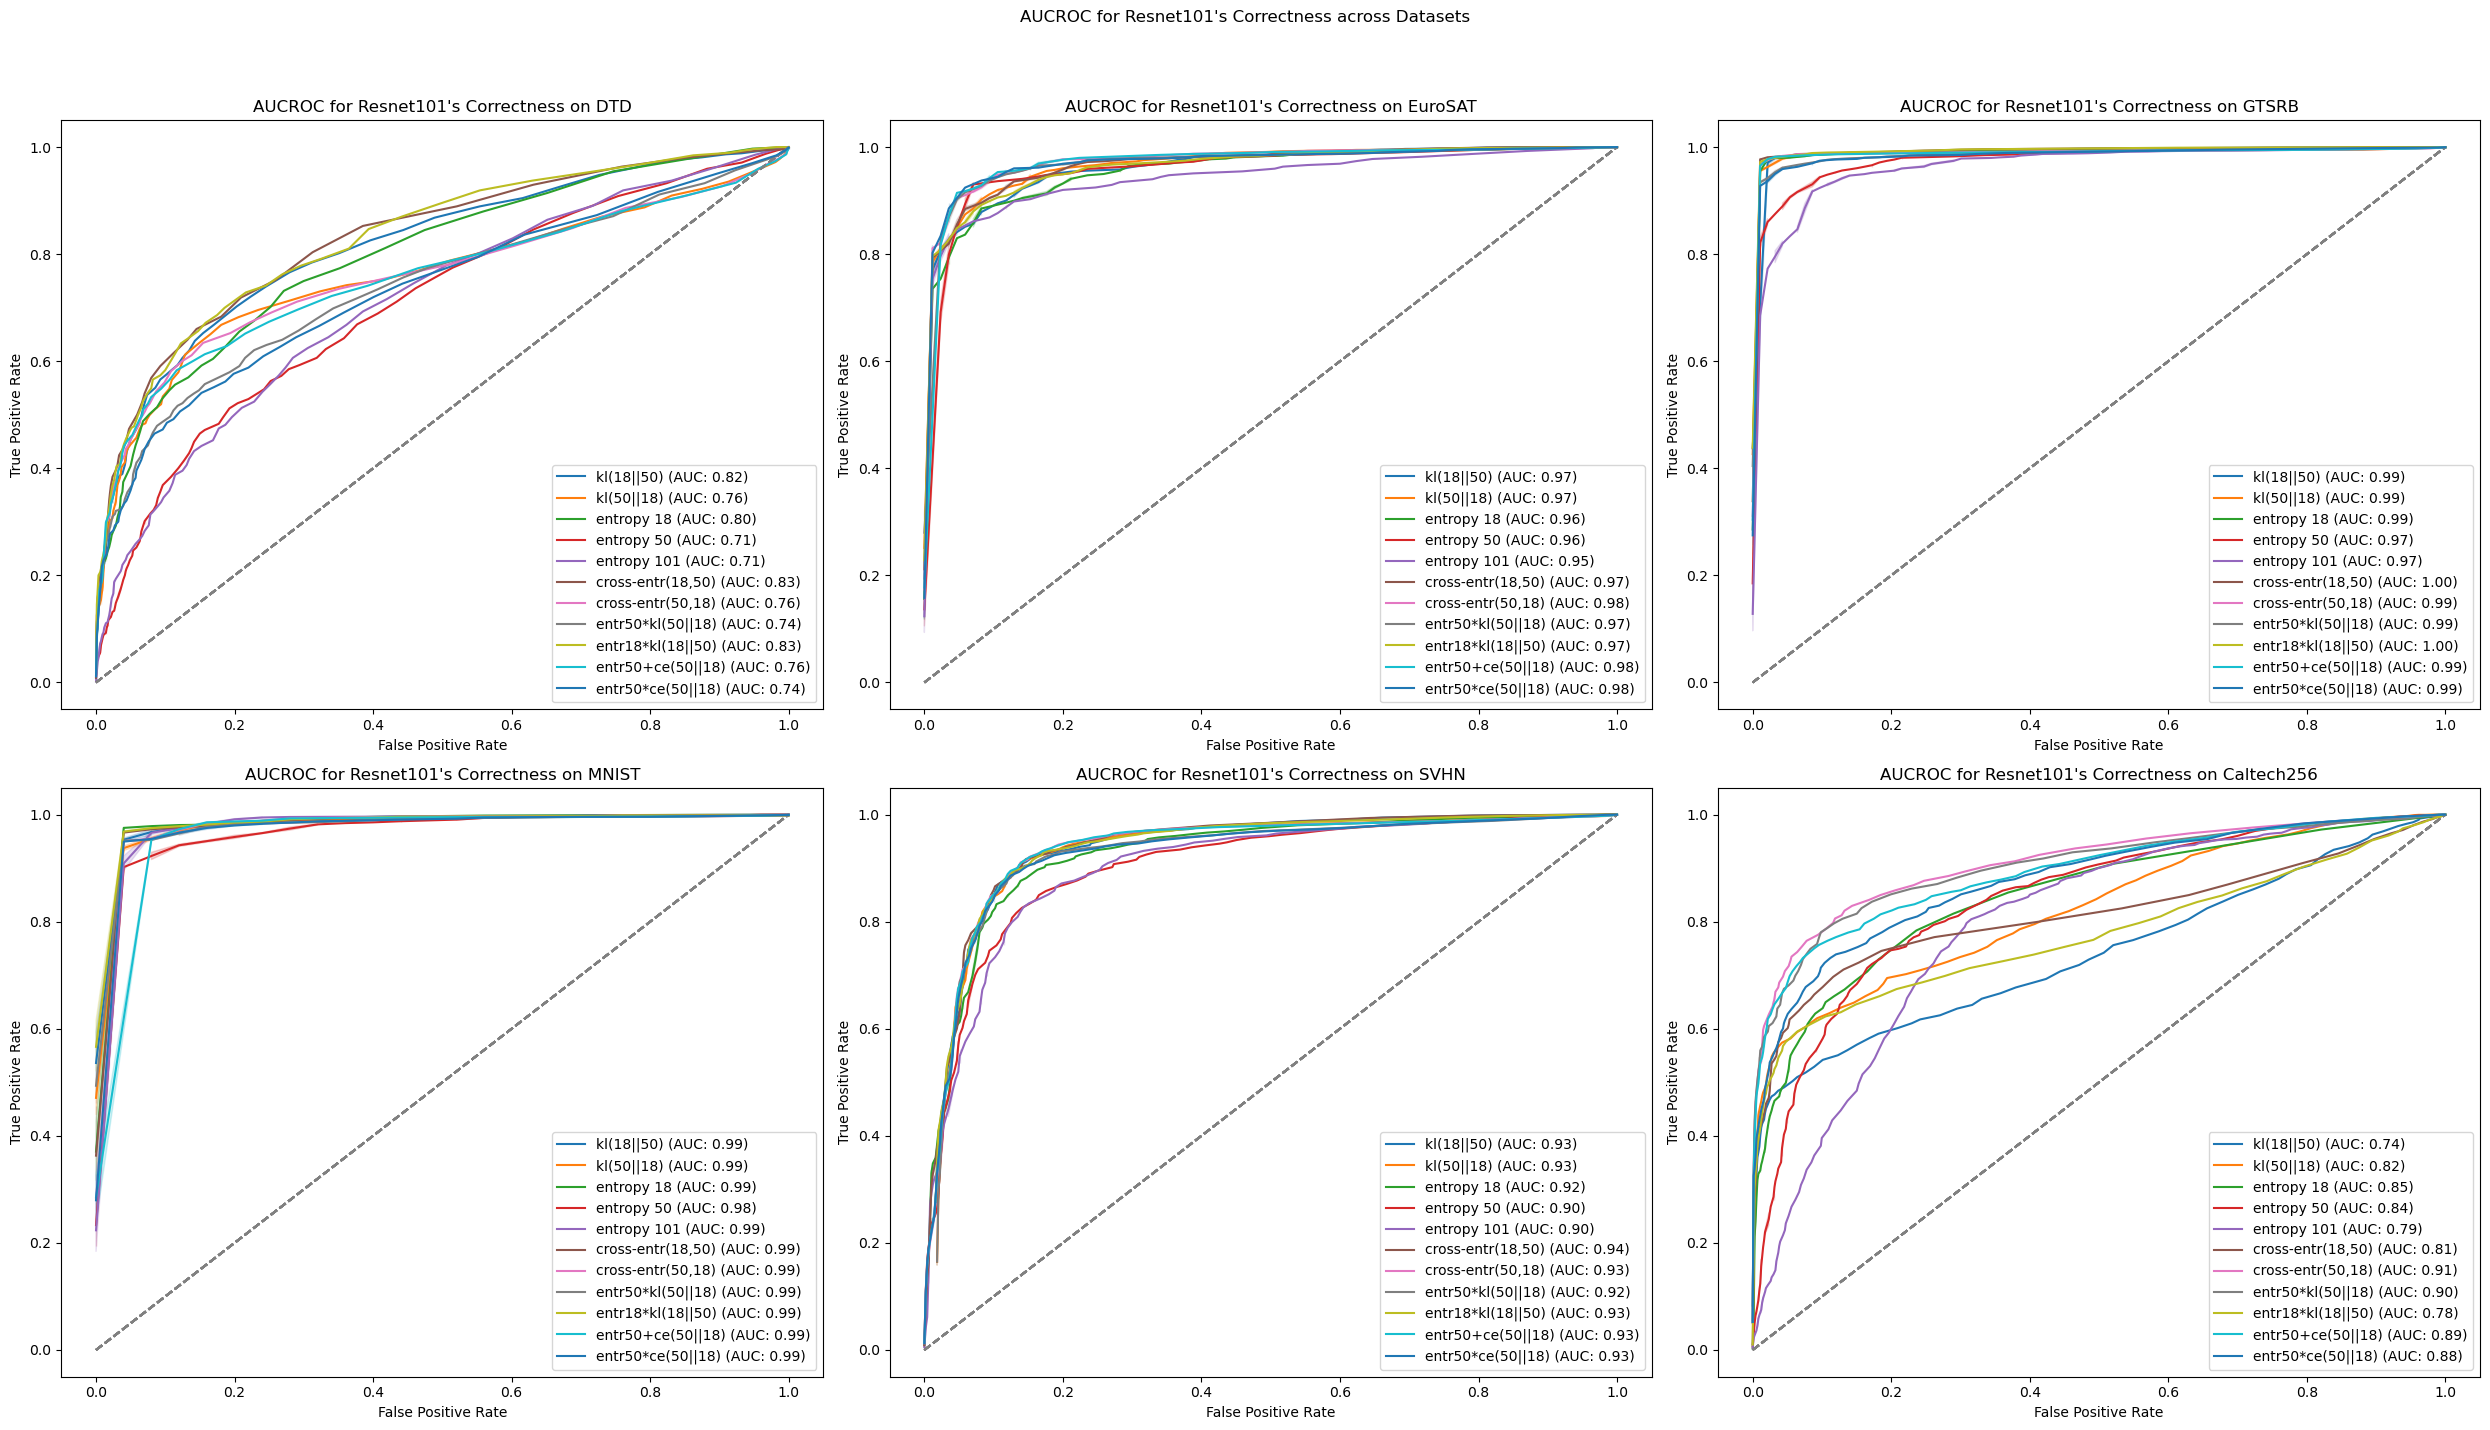

In [35]:
fig, axes = plt.subplots(nrow, ncol, figsize=(25, 15))

for i, ds in enumerate(datasets):
    pred = pd.read_csv(f"prediction_{ds}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"uncertainty_{ds}.csv", index_col="Unnamed: 0")
    
    metrics = [
        (np.log(unc_pred["kl_18_50"]).clip(-100,100), "kl(18||50)"),
        (np.log(unc_pred["kl_50_18"]), "kl(50||18)"),
        (np.log(unc_pred["ent_18"]), "entropy 18"),
        (np.log(unc_pred["ent_50"]), "entropy 50"),
        (np.log(unc_pred["ent_101"]), "entropy 101"),
        (np.log(unc_pred["ce_18_50"]).clip(-100,100), "cross-entr(18,50)"),
        (np.log(unc_pred["ce_50_18"]), "cross-entr(50,18)"),
        (np.log(unc_pred["ent_50"] * unc_pred["kl_50_18"]), "entr50*kl(50||18)"),
        (np.log(unc_pred["ent_18"] * unc_pred["kl_18_50"]).clip(-100,100), "entr18*kl(18||50)"),
        (np.log(unc_pred["ent_50"] + unc_pred["ce_50_18"]), "entr50+ce(50||18)"),
        (np.log(unc_pred["ent_50"] * unc_pred["ce_50_18"]), "entr50*ce(50||18)")
    ]
    
    ax = axes[i // ncol, i % ncol]
    for metric, label in metrics:
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
        print(label)
        auroc(pred["pred18"], pred["target"], metric, label, ax)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"AUCROC for Resnet101's Correctness on {ds}")
        ax.legend(loc="lower right")

plt.suptitle("AUCROC for Resnet101's Correctness across Datasets")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
# plt.savefig(f"artifacts/{nbn}aucroc.png")
plt.show()